### aim: understand spatial/latitudinal distribution of functional group composition in different models

### date: 

In [57]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [58]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [59]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## maps

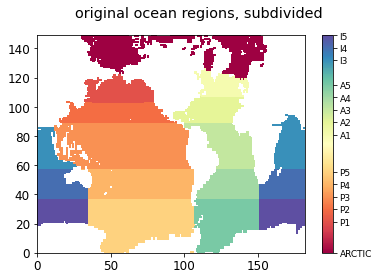

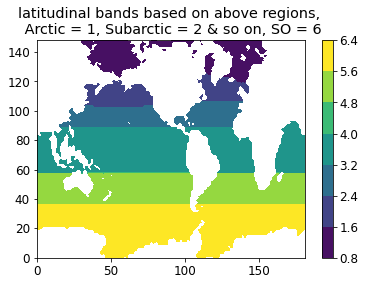

In [60]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('original ocean regions, subdivided')

fact = 0.2
#fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    #plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
# plt.legend(ncol = 5, fontsize = 10)
# plt.suptitle('check that norm of colours works')

plt.figure()
mask_latbands = np.copy(maskno)

mask_latbands[maskno == 0.5] = 1
mask_latbands[(maskno == 1) | (maskno == 2.4)] = 2
mask_latbands[(maskno == 1.2) | (maskno == 2.6)] = 3
mask_latbands[(maskno == 1.4) | (maskno == 2.8) | (maskno == 3.6)] = 4
mask_latbands[(maskno == 1.6) | (maskno == 3.0) | (maskno == 3.8)] = 5
mask_latbands[(maskno == 1.8) | (maskno == 3.2) | (maskno == 4.0)] = 6

w = plt.contourf(mask_latbands, vmin = 1, vmax = 6)
plt.title('latitudinal bands based on above regions, \n Arctic = 1, Subarctic = 2 & so on, SO = 6')
plt.colorbar(w)

define depths, sizes

In [61]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

csize_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]

cdepth = tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]
cdepth_broad = np.zeros([4,31,149,182])
for i in range(0,4):
    cdepth_broad[i,:,:,:] = cdepth

choose whether to run extraction, whether to print variable names!

In [62]:
horse = False

In [63]:
def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist



def gimme_plant(ds, plant):
    '''
    takes ds of type ptrc, calculates seasonal by-lat depth-integrated means of different biological tracers.
    '''
    seas_lat_phyto = np.zeros([4,6]) #storage array
    #print(ds[plant].long_name)
    tmn = ds[plant].groupby('time_counter.season').mean('time_counter') #get seasonal mean1
    tmn_test = tmn*cdepth_broad*1000 #* cdepth * 1000 # units in mols/m2 = mols/L * m * L/m3, each depth cell now in mol/m2
    tmn_molm2 = np.nansum(tmn_test, axis = 1) #integrate, ie sum

    for s in range(0,4):        
        for b in range(0,6):
            tmn_molm2_formask = np.copy(tmn_molm2) #copy for manipulations
            tmn_molm2_formask_tseas = tmn_molm2_formask[s,:,:] # 
            tmn_molm2_formask_tseas[mask_latbands != b+1] = 0
            csize_formask = np.copy(csize_broad[0,:,:])
            csize_formask[mask_latbands != b+1] = 0
            seas_lat_phyto[s,b] = np.ma.average(tmn_molm2_formask_tseas[:,:], weights=csize_formask)

    return seas_lat_phyto



def make_tracer_seas_lat_ptrc(yrst, yrend, tr, baseDir = '/gpfs/data/greenocean/software/runs/'):
    
    tdir = './seas_lat_avg/'
    tnam = f'PTRC_seas_lat_{tr}_{yrst}-{yrend}.nc'
    
    seas = ['DJF','MAM','JJA','SON']
    
    dtype = 'ptrc_T'
    baseDir = '/gpfs/data/greenocean/software/runs/'
    ylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
    ds = xr.open_mfdataset(ylist)
    

    seas_lat_DIA = gimme_plant(ds, 'DIA') #phyto
    seas_lat_MIX = gimme_plant(ds, 'MIX')
    seas_lat_COC = gimme_plant(ds, 'COC')
    seas_lat_PIC = gimme_plant(ds, 'PIC')
    seas_lat_PHA = gimme_plant(ds, 'PHA')
    seas_lat_FIX = gimme_plant(ds, 'FIX')

    seas_lat_BAC = gimme_plant(ds, 'BAC') #bacterai

    seas_lat_PRO = gimme_plant(ds, 'PRO') #zoos
    seas_lat_PTE = gimme_plant(ds, 'PTE')
    seas_lat_MES = gimme_plant(ds, 'MES')
    seas_lat_GEL = gimme_plant(ds, 'GEL')
    seas_lat_MAC = gimme_plant(ds, 'MAC')
    
    data_vars = {'DIA':(['season',  'lat_band'], seas_lat_DIA,
                         {'units': 'mol/m2'}),
                 'MIX':(['season',  'lat_band'], seas_lat_MIX,
                         {'units': 'mol/m2'}),
                 'COC':(['season',  'lat_band'], seas_lat_COC,
                         {'units': 'mol/m2'}),
                 'PIC':(['season',  'lat_band'], seas_lat_PIC,
                         {'units': 'mol/m2'}),
                 'PHA':(['season',  'lat_band'], seas_lat_PHA,
                         {'units': 'mol/m2'}), 
                 'FIX':(['season',  'lat_band'], seas_lat_FIX,
                         {'units': 'mol/m2'}),
                 
                 'BAC':(['season',  'lat_band'], seas_lat_BAC,
                         {'units': 'mol/m2'}),
                 
                 'PRO':(['season',  'lat_band'], seas_lat_PRO,
                         {'units': 'mol/m2'}),
                 'PTE':(['season',  'lat_band'], seas_lat_PTE,
                         {'units': 'mol/m2'}),
                 'MES':(['season',  'lat_band'], seas_lat_MES,
                         {'units': 'mol/m2'}),
                 'GEL':(['season',  'lat_band'], seas_lat_GEL,
                         {'units': 'mol/m2'}),
                 'MAC':(['season',  'lat_band'], seas_lat_MAC,
                         {'units': 'mol/m2'}),
                }

    # define coordinates
    coords = {'season': (['season'], ['DJF','MAM', 'JJA', 'SON']),\
             'lat_band': (['lat_band'], np.arange(1,7,1)),}

    # define global attributes
    attrs = {'made in':'ecosystemLooks/seasonalFxnlGroupComposition.ipynb',
             'latitude bands': 'see notebook, 1 is arctic, 6 is SO',
            }
    
    # create dataset
    ds = xr.Dataset(data_vars=data_vars,
                    coords=coords,
                    attrs=attrs)

    ds.to_netcdf(f'{tdir}{tnam}')
    


In [64]:

if horse:
    
    yrst = 2019; yrend = 2020; tr = 'TOM12_TJ_1ASA'; dtype = 'ptrc_T'
    baseDir = '/gpfs/data/greenocean/software/runs/'
    ylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
    ds = xr.open_mfdataset(ylist)
    dtype = 'diad_T'
    ylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
    ds2 = xr.open_mfdataset(ylist)

    ptrc_keys = list(ds.keys())
    diad_keys = list(ds2.keys())

    print('ptrc keys')
    for i in range(4,len(ptrc_keys)):
        print(f'{ptrc_keys[i]}, {ds[ptrc_keys[i]].long_name}')
    print()
    print('diad keys') 
    for i in range(4,len(diad_keys)):
        print(f'{diad_keys[i]}, {ds2[diad_keys[i]].long_name}')

In [65]:
if horse:
    yrst = 2015; yrend = 2020; tr = 'TOM12_RW_3G76'; 
    make_tracer_seas_lat_ptrc(yrst, yrend, tr)
    yrst = 2015; yrend = 2020; tr = 'TOM12_DW_GA01'; 
    make_tracer_seas_lat_ptrc(yrst, yrend, tr)
    yrst = 2015; yrend = 2020; tr = 'TOM12_DW_WE43'; 
    make_tracer_seas_lat_ptrc(yrst, yrend, tr)
    yrst = 2015; yrend = 2020; tr = 'TOM12_TJ_1ASA'; 
    make_tracer_seas_lat_ptrc(yrst, yrend, tr)

['./seas_lat_avg/PTRC_seas_lat_TOM12_DW_GA01_2015-2020.nc']
['./seas_lat_avg/PTRC_seas_lat_TOM12_RW_3G76_2015-2020.nc']
['./seas_lat_avg/PTRC_seas_lat_TOM12_TJ_1ASA_2015-2020.nc']
['./seas_lat_avg/PTRC_seas_lat_TOM12_DW_WE43_2015-2020.nc']


<Figure size 432x288 with 0 Axes>

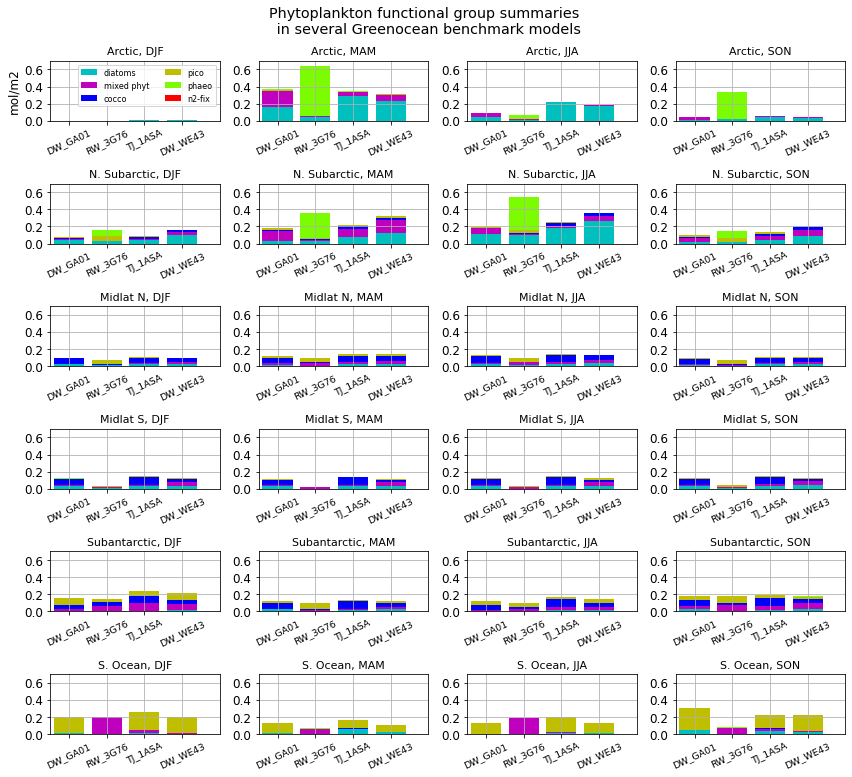

In [66]:
mods = ['DW_GA01','RW_3G76','TJ_1ASA','DW_WE43']

plt.figure()

fact = 1
fig, axs = plt.subplots(6,4, figsize=(12*fact, 11*fact), facecolor='w', edgecolor='k')

bands = ['Arctic', 'N. Subarctic', 'Midlat N', 'Midlat S', 'Subantarctic', 'S. Ocean']
seas = ['DJF','MAM', 'JJA', 'SON']

for m in range(0,len(mods)):
    tnc = glob.glob(f'./seas_lat_avg/*{mods[m]}*')
    print(tnc)
    tds = xr.open_mfdataset(tnc[0])
    tds

    for s in range(0,4):
        for b in range(0,6):

            tdia = tds['DIA'][s,b]; diacol = 'c'
            tmix = tds['MIX'][s,b]; mixcol = 'm'
            tcoc = tds['COC'][s,b]; coccol = 'b'
            tpic = tds['PIC'][s,b]; piccol = 'y'
            tpha = tds['PHA'][s,b]; phacol = 'lawngreen'
            tfix = tds['FIX'][s,b]; fixcol = 'r'

            if ((b == 0) & (s == 0) & (m == 0)):
                axs[b, s].bar(m, tdia, color = diacol, label="diatoms")
                axs[b, s].bar(m, tmix, bottom = tdia, color = mixcol, label="mixed phyt")
                axs[b, s].bar(m, tcoc, bottom = tdia + tmix, color = coccol, label="cocco")
                axs[b, s].bar(m, tpic, bottom = tdia + tmix + tcoc, color = piccol, label="pico")
                axs[b, s].bar(m, tpha, bottom = tdia + tmix + tcoc + tpic, color = phacol, label="phaeo")
                axs[b, s].bar(m, tfix, bottom = tdia + tmix + tcoc + tpic + tpha, color = fixcol, label="n2-fix")
                axs[0,0].legend(fontsize = 8, ncol = 2)
            else:
                axs[b, s].bar(m, tdia, color = diacol)
                axs[b, s].bar(m, tmix, bottom = tdia, color = mixcol)
                axs[b, s].bar(m, tcoc, bottom = tdia + tmix, color = coccol)
                axs[b, s].bar(m, tpic, bottom = tdia + tmix + tcoc, color = piccol)
                axs[b, s].bar(m, tpha, bottom = tdia + tmix + tcoc + tpic, color = phacol)


                # axs[b, s].scatter(p, ps[p][s,b], marker = 'o', color = 'r')
                # axs[b, s].scatter(p, ps[p][s,b], marker = 'o', color = 'r')
            if (m==0):
                axs[b, s].set_xlim([-0.5,len(mods)])
                axs[b, s].set_ylim([0,0.7])
                axs[b, s].set_title(f'{bands[b]}, {seas[s]}', fontsize = 11)
                axs[b, s].set_xticks(np.arange(0,len(mods),1))
                axs[b, s].set_xticklabels(mods, rotation = 25, fontsize = 9.5)
                axs[b, s].set_yticks(np.arange(0,0.8,0.2))
                axs[b, s].grid()
                axs[0, 0].set_ylabel('mol/m2')

fig.suptitle('Phytoplankton functional group summaries \n in several Greenocean benchmark models')
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

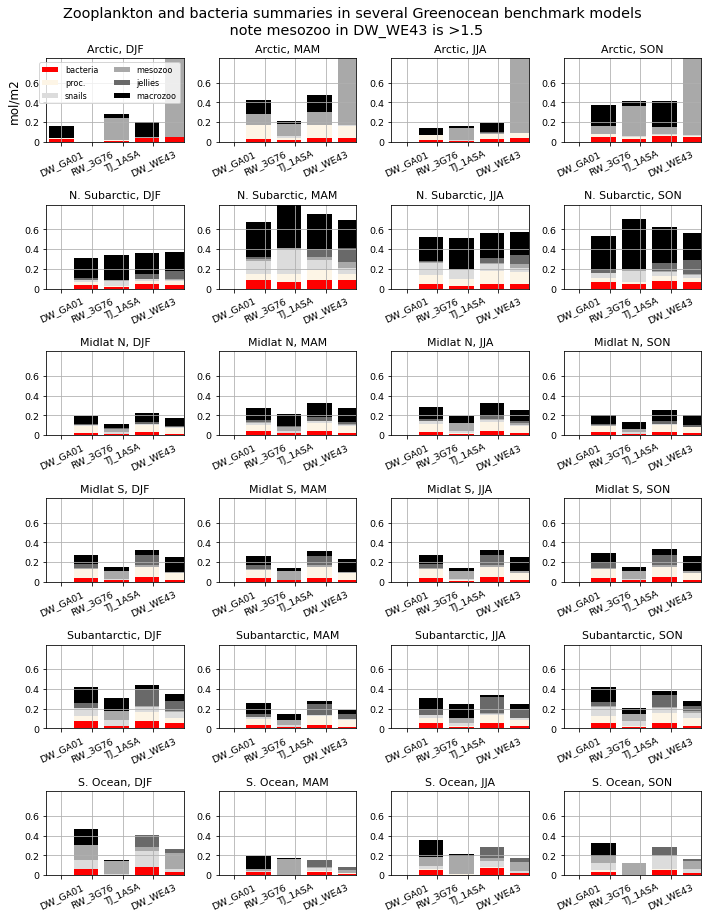

In [67]:


tw = 0.8
mods = ['DW_GA01','RW_3G76','TJ_1ASA','DW_WE43']

plt.figure()

fact = 1
fig, axs = plt.subplots(6,4, figsize=(10*fact, 13*fact), facecolor='w', edgecolor='k')

bands = ['Arctic', 'N. Subarctic', 'Midlat N', 'Midlat S', 'Subantarctic', 'S. Ocean']
seas = ['DJF','MAM', 'JJA', 'SON']

for m in range(0,len(mods)):
    tnc = glob.glob(f'./seas_lat_avg/*{mods[m]}*')
    tds = xr.open_mfdataset(tnc[0])
    tds

    for s in range(0,4):
        for b in range(0,6):

            tdia = tds['DIA'][s,b]; diacol = 'c'
            tmix = tds['MIX'][s,b]; mixcol = 'm'
            tcoc = tds['COC'][s,b]; coccol = 'b'
            tpic = tds['PIC'][s,b]; piccol = 'y'
            tpha = tds['PHA'][s,b]; phacol = 'lawngreen'
            tfix = tds['FIX'][s,b]; fixcol = 'gold'
            
            tbac = tds['BAC'][s,b]; baccol = 'r'
            tpro = tds['PRO'][s,b]; procol = 'oldlace'
            tpte = tds['PTE'][s,b]; ptecol = 'gainsboro'
            tmes = tds['MES'][s,b]; mescol = 'darkgray'
            tgel = tds['GEL'][s,b]; gelcol = 'dimgrey'
            tmac = tds['MAC'][s,b]; maccol = 'k'

            if ((b == 0) & (s == 0) & (m == 0)):
                # axs[b, s].bar(m, tdia, color = diacol, label="diatoms", width = tw)
                # axs[b, s].bar(m, tmix, bottom = tdia, color = mixcol, label="mixed phyt", width = tw)
                # axs[b, s].bar(m, tcoc, bottom = tdia + tmix, color = coccol, label="cocco", width = tw)
                # axs[b, s].bar(m, tpic, bottom = tdia + tmix + tcoc, color = piccol, label="pico", width = tw)
                # axs[b, s].bar(m, tpha, bottom = tdia + tmix + tcoc + tpic, color = phacol, label="phaeo", width = tw)
                # axs[b, s].bar(m, tfix, bottom = tdia + tmix + tcoc + tpic + tpha, color = fixcol, label="n2-fix", width = tw)
                
                axs[b, s].bar(m, tbac, color = baccol, label="bacteria", width = tw)
                axs[b, s].bar(m, tpro, bottom = tbac, color = procol, label="proc.", width = tw)
                axs[b, s].bar(m, tpte, bottom = tbac+tpro, color = ptecol, label="snails", width = tw)
                axs[b, s].bar(m, tmes, bottom = tbac+tpro+tpte, color = mescol, label="mesozoo", width = tw)
                axs[b, s].bar(m, tgel, bottom = tbac+tpro+tpte+tmes, color = gelcol, label="jellies", width = tw)
                axs[b, s].bar(m, tmac, bottom = tbac+tpro+tpte+tmes+tgel, color = maccol, label="macrozoo", width = tw)
             
                axs[0,0].legend(fontsize = 8, ncol = 2)
            else:
#                 axs[b, s].bar(m, tdia, color = diacol, width = tw)
#                 axs[b, s].bar(m, tmix, bottom = tdia, color = mixcol, width = tw)
#                 axs[b, s].bar(m, tcoc, bottom = tdia + tmix, color = coccol, width = tw)
#                 axs[b, s].bar(m, tpic, bottom = tdia + tmix + tcoc, color = piccol, width = tw)
#                 axs[b, s].bar(m, tpha, bottom = tdia + tmix + tcoc + tpic, color = phacol, width = tw)
                
                axs[b, s].bar(m+tw, tbac, color = baccol, width = tw)
                axs[b, s].bar(m+tw, tbac, color = baccol, width = tw)
                axs[b, s].bar(m+tw, tpro, bottom = tbac, color = procol, width = tw)
                axs[b, s].bar(m+tw, tpte, bottom = tbac+tpro, color = ptecol, width = tw)
                axs[b, s].bar(m+tw, tmes, bottom = tbac+tpro+tpte, color = mescol, width = tw)
                axs[b, s].bar(m+tw, tgel, bottom = tbac+tpro+tpte+tmes, color = gelcol, width = tw)
                axs[b, s].bar(m+tw, tmac, bottom = tbac+tpro+tpte+tmes+tgel, color = maccol, width = tw)

            if (m==0):
                axs[b, s].set_xlim([-0.5,len(mods)])
                axs[b, s].set_ylim([0,0.85])
                axs[b, s].set_title(f'{bands[b]}, {seas[s]}', fontsize = 11)
                axs[b, s].set_xticks(np.arange(0,len(mods),1))
                
                axs[b, s].set_xticklabels(mods, rotation = 25, fontsize = 9.5)
                axs[b, s].set_yticks(np.arange(0,0.8,0.2))
                axs[b, s].set_yticklabels([0, 0.2, 0.4, 0.6], fontsize = 9.5)
                axs[b, s].grid()
                axs[0, 0].set_ylabel('mol/m2')

fig.suptitle('Zooplankton and bacteria summaries in several Greenocean benchmark models \n note mesozoo in DW_WE43 is >1.5')
plt.tight_layout()

['./seas_lat_avg/PTRC_seas_lat_TOM12_DW_GA01_2015-2020.nc']
['./seas_lat_avg/PTRC_seas_lat_TOM12_RW_3G76_2015-2020.nc']
['./seas_lat_avg/PTRC_seas_lat_TOM12_TJ_1ASA_2015-2020.nc']
['./seas_lat_avg/PTRC_seas_lat_TOM12_DW_WE43_2015-2020.nc']


<Figure size 432x288 with 0 Axes>

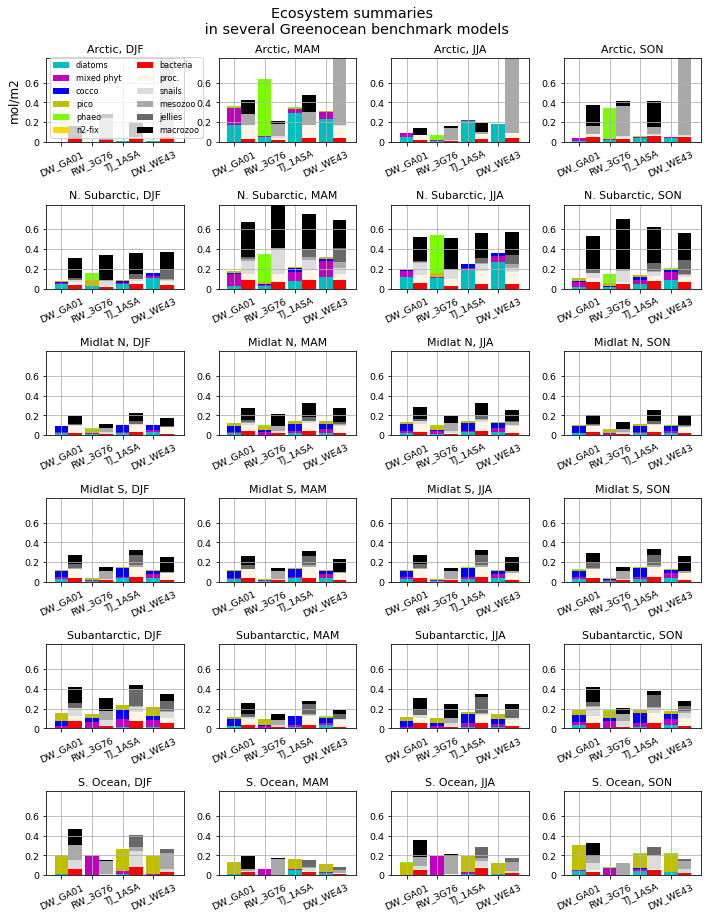

In [68]:
#                  'BAC':(['season',  'lat_band'], seas_lat_BAC,
#                          {'units': 'mol/m2'}),
                 
#                  'PRO':(['season',  'lat_band'], seas_lat_PRO,
#                          {'units': 'mol/m2'}),
#                  'PTE':(['season',  'lat_band'], seas_lat_PTE,
#                          {'units': 'mol/m2'}),
#                  'MES':(['season',  'lat_band'], seas_lat_MES,
#                          {'units': 'mol/m2'}),
#                  'GEL':(['season',  'lat_band'], seas_lat_GEL,
#                          {'units': 'mol/m2'}),
#                  'MAC':(['season',  'lat_band'], seas_lat_MAC,
#                          {'units': 'mol/m2'}),

tw = 0.45
mods = ['DW_GA01','RW_3G76','TJ_1ASA','DW_WE43']

plt.figure()

fact = 1
fig, axs = plt.subplots(6,4, figsize=(10*fact, 13*fact), facecolor='w', edgecolor='k')

bands = ['Arctic', 'N. Subarctic', 'Midlat N', 'Midlat S', 'Subantarctic', 'S. Ocean']
seas = ['DJF','MAM', 'JJA', 'SON']

for m in range(0,len(mods)):
    tnc = glob.glob(f'./seas_lat_avg/*{mods[m]}*')
    print(tnc)
    tds = xr.open_mfdataset(tnc[0])
    tds

    for s in range(0,4):
        for b in range(0,6):

            tdia = tds['DIA'][s,b]; diacol = 'c'
            tmix = tds['MIX'][s,b]; mixcol = 'm'
            tcoc = tds['COC'][s,b]; coccol = 'b'
            tpic = tds['PIC'][s,b]; piccol = 'y'
            tpha = tds['PHA'][s,b]; phacol = 'lawngreen'
            tfix = tds['FIX'][s,b]; fixcol = 'gold'
            
            tbac = tds['BAC'][s,b]; baccol = 'r'
            tpro = tds['PRO'][s,b]; procol = 'oldlace'
            tpte = tds['PTE'][s,b]; ptecol = 'gainsboro'
            tmes = tds['MES'][s,b]; mescol = 'darkgray'
            tgel = tds['GEL'][s,b]; gelcol = 'dimgrey'
            tmac = tds['MAC'][s,b]; maccol = 'k'

            if ((b == 0) & (s == 0) & (m == 0)):
                axs[b, s].bar(m, tdia, color = diacol, label="diatoms", width = tw)
                axs[b, s].bar(m, tmix, bottom = tdia, color = mixcol, label="mixed phyt", width = tw)
                axs[b, s].bar(m, tcoc, bottom = tdia + tmix, color = coccol, label="cocco", width = tw)
                axs[b, s].bar(m, tpic, bottom = tdia + tmix + tcoc, color = piccol, label="pico", width = tw)
                axs[b, s].bar(m, tpha, bottom = tdia + tmix + tcoc + tpic, color = phacol, label="phaeo", width = tw)
                axs[b, s].bar(m, tfix, bottom = tdia + tmix + tcoc + tpic + tpha, color = fixcol, label="n2-fix", width = tw)
                
                axs[b, s].bar(m+tw, tbac, color = baccol, label="bacteria", width = tw)
                axs[b, s].bar(m+tw, tpro, bottom = tbac, color = procol, label="proc.", width = tw)
                axs[b, s].bar(m+tw, tpte, bottom = tbac+tpro, color = ptecol, label="snails", width = tw)
                axs[b, s].bar(m+tw, tmes, bottom = tbac+tpro+tpte, color = mescol, label="mesozoo", width = tw)
                axs[b, s].bar(m+tw, tgel, bottom = tbac+tpro+tpte+tmes, color = gelcol, label="jellies", width = tw)
                axs[b, s].bar(m+tw, tmac, bottom = tbac+tpro+tpte+tmes+tgel, color = maccol, label="macrozoo", width = tw)
             
                axs[0,0].legend(fontsize = 8, ncol = 2)
            else:
                axs[b, s].bar(m, tdia, color = diacol, width = tw)
                axs[b, s].bar(m, tmix, bottom = tdia, color = mixcol, width = tw)
                axs[b, s].bar(m, tcoc, bottom = tdia + tmix, color = coccol, width = tw)
                axs[b, s].bar(m, tpic, bottom = tdia + tmix + tcoc, color = piccol, width = tw)
                axs[b, s].bar(m, tpha, bottom = tdia + tmix + tcoc + tpic, color = phacol, width = tw)
                
                axs[b, s].bar(m+tw, tbac, color = baccol, width = tw)
                axs[b, s].bar(m+tw, tbac, color = baccol, width = tw)
                axs[b, s].bar(m+tw, tpro, bottom = tbac, color = procol, width = tw)
                axs[b, s].bar(m+tw, tpte, bottom = tbac+tpro, color = ptecol, width = tw)
                axs[b, s].bar(m+tw, tmes, bottom = tbac+tpro+tpte, color = mescol, width = tw)
                axs[b, s].bar(m+tw, tgel, bottom = tbac+tpro+tpte+tmes, color = gelcol, width = tw)
                axs[b, s].bar(m+tw, tmac, bottom = tbac+tpro+tpte+tmes+tgel, color = maccol, width = tw)

            if (m==0):
                axs[b, s].set_xlim([-0.5,len(mods)])
                axs[b, s].set_ylim([0,0.85])
                axs[b, s].set_title(f'{bands[b]}, {seas[s]}', fontsize = 11)
                axs[b, s].set_xticks(np.arange(0,len(mods),1))
                
                axs[b, s].set_xticklabels(mods, rotation = 25, fontsize = 9.5)
                axs[b, s].set_yticks(np.arange(0,0.8,0.2))
                axs[b, s].set_yticklabels([0, 0.2, 0.4, 0.6], fontsize = 9.5)
                axs[b, s].grid()
                axs[0, 0].set_ylabel('mol/m2')

fig.suptitle('Ecosystem summaries \n in several Greenocean benchmark models')
plt.tight_layout()

In [69]:
# # plants = ['DIA', 'MIX', 'COC', 'PIC', 'PHA', 'FIX']


# seas_lat_DIA = gimme_plant(ds, 'DIA')
# seas_lat_MIX = gimme_plant(ds, 'MIX')
# seas_lat_COC = gimme_plant(ds, 'COC')
# seas_lat_PIC = gimme_plant(ds, 'PIC')
# seas_lat_PHA = gimme_plant(ds, 'PHA')
# seas_lat_FIX = gimme_plant(ds, 'FIX')

# seas_lat_BAC = gimme_plant(ds, 'BAC')
# seas_lat_PRO = gimme_plant(ds, 'PRO')
# seas_lat_PTE = gimme_plant(ds, 'PTE')
# seas_lat_GEL = gimme_plant(ds, 'GEL')
# seas_lat_MAC = gimme_plant(ds, 'MAC')


In [70]:
# fact = 1
# fig, axs = plt.subplots(6,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
# #axs = axs.ravel()

# ps = [seas_lat_DIA, seas_lat_MIX, seas_lat_COC, seas_lat_PIC, seas_lat_PHA, seas_lat_FIX]
# bands = ['Arctic', 'N. Subarctic', 'Midlat N', 'Midlat S', 'Subantarctic', 'S. Ocean']
# seas = ['DJF','MAM', 'JJA', 'SON']

# for s in range(0,4):
#     for b in range(0,6):
#         for p in range(0,6):
#             axs[b, s].scatter(p, ps[p][s,b], marker = 'o', color = 'r')
#             axs[b, s].scatter(p, ps[p][s,b], marker = 'o', color = 'r')
            
#             axs[b, s].set_xlim([-0.5,5.5])
#             axs[b, s].set_ylim([0,0.25])
#             axs[b, s].set_title(f'{bands[b]}, {seas[s]}')
#             axs[b, s].set_xticks(np.arange(0,6,1))
#             axs[b, s].set_xticklabels(plants)

# plt.tight_layout()

In [71]:
np.nanmax(mask_latbands)

6.0

In [72]:
tds

<xarray.Dataset>
Dimensions:   (lat_band: 6, season: 4)
Coordinates:
  * season    (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * lat_band  (lat_band) int64 1 2 3 4 5 6
Data variables:
    DIA       (season, lat_band) float64 dask.array<chunksize=(4, 6), meta=np.ndarray>
    MIX       (season, lat_band) float64 dask.array<chunksize=(4, 6), meta=np.ndarray>
    COC       (season, lat_band) float64 dask.array<chunksize=(4, 6), meta=np.ndarray>
    PIC       (season, lat_band) float64 dask.array<chunksize=(4, 6), meta=np.ndarray>
    PHA       (season, lat_band) float64 dask.array<chunksize=(4, 6), meta=np.ndarray>
    FIX       (season, lat_band) float64 dask.array<chunksize=(4, 6), meta=np.ndarray>
    BAC       (season, lat_band) float64 dask.array<chunksize=(4, 6), meta=np.ndarray>
    PRO       (season, lat_band) float64 dask.array<chunksize=(4, 6), meta=np.ndarray>
    PTE       (season, lat_band) float64 dask.array<chunksize=(4, 6), meta=np.ndarray>
    MES       (season, lat_band) float64 dask.array<chunksize=(4, 6), meta=np.ndarray>
    GEL       (season, lat_band) float64 dask.array<chunksize=(4, 6), meta=np.ndarray>
    MAC       (season, lat_band) float64 dask.array<chunksize=(4, 6), meta=np.ndarray>
Attributes:
    made in:         ecosystemLooks/seasonalFxnlGroupComposition.ipynb
    latitude bands:  see notebook, 1 is arctic, 6 is SO

In [73]:
w